In [1]:
###
### Import required libraries
###

import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (30.0, 15.0)


import operator
import datetime
import re
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, GRU, CuDNNGRU, SimpleRNN, ConvLSTM2D, Dropout, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils import plot_model

from keras.models import Model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

/data/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
###
### Read Data From previously saved dataframe
###

df = pd.read_csv('../data/bitstamp_minute_data.csv', sep=',')
print df.shape
df.sort_values(by=['year', 'month', 'day_of_month', 'hour'], inplace=True)
df.head()

(3161057, 17)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,datetime,datetime_pandas,day_of_month,month,year,weekday,week,hour,minute
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:52:00,2011-12-31 07:52:00,31,12,2011,5,52,7,52
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:53:00,2011-12-31 07:53:00,31,12,2011,5,52,7,53
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:54:00,2011-12-31 07:54:00,31,12,2011,5,52,7,54
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:55:00,2011-12-31 07:55:00,31,12,2011,5,52,7,55
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:56:00,2011-12-31 07:56:00,31,12,2011,5,52,7,56


In [7]:
print df.columns.values
df.sort_values(by='Timestamp', inplace=True)
features = ['Open', 'High', 'Low', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'day_of_month', 'month', 'year', 'weekday', 'week', 'hour', 'minute', 'Close']
hour_features = ['Open', 'High', 'Low', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'day_of_month', 'month', 'year', 'weekday', 'week', 'hour', 'Close']
print features
print df.shape

['Timestamp' 'Open' 'High' 'Low' 'Close' 'Volume_(BTC)'
 'Volume_(Currency)' 'Weighted_Price' 'datetime' 'datetime_pandas'
 'day_of_month' 'month' 'year' 'weekday' 'week' 'hour' 'minute']
['Open', 'High', 'Low', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'day_of_month', 'month', 'year', 'weekday', 'week', 'hour', 'minute', 'Close']
(3161057, 17)


In [8]:
###
### Date generation
###

df['datetime_pandas'] = pd.to_datetime(df['datetime_pandas'])
df['Date'] = df['datetime_pandas'].apply(lambda x: x.date())
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date']<'2018-01-01']
del df['Timestamp']
del df['datetime']
del df['datetime_pandas']
df.tail(30)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,day_of_month,month,year,weekday,week,hour,minute,Date
3150946,13950.00,13950.00,13930.00,13930.00,1.683328,23473.988712,13944.990705,31,12,2017,6,52,23,30,2017-12-31
3150947,13930.00,13951.59,13930.00,13951.59,4.376772,61024.849398,13942.891170,31,12,2017,6,52,23,31,2017-12-31
3150948,13950.06,13960.00,13945.21,13960.00,14.119377,197096.693070,13959.304855,31,12,2017,6,52,23,32,2017-12-31
3150949,13970.07,13970.07,13931.34,13957.10,0.309732,4318.640489,13943.146579,31,12,2017,6,52,23,33,2017-12-31
3150950,13957.19,13957.19,13957.19,13957.19,1.280621,17873.872569,13957.190000,31,12,2017,6,52,23,34,2017-12-31
3150951,13957.19,13993.92,13930.00,13988.34,15.435691,215218.037020,13942.883282,31,12,2017,6,52,23,35,2017-12-31
3150952,13980.80,13980.80,13963.21,13963.89,1.825191,25487.410961,13964.245238,31,12,2017,6,52,23,36,2017-12-31
3150953,13999.91,13999.91,13963.22,13987.68,0.587565,8217.678618,13985.980690,31,12,2017,6,52,23,37,2017-12-31
3150954,13931.60,13999.81,13931.60,13999.81,4.161676,58148.432686,13972.358169,31,12,2017,6,52,23,38,2017-12-31
3150955,13932.16,13999.98,13932.16,13957.50,3.054607,42680.903879,13972.634618,31,12,2017,6,52,23,39,2017-12-31


In [9]:
df = df.sort_values(by=['Date', 'hour', 'minute'], ascending=True)
df.reset_index(inplace=True)
df = df[features]
print df.shape

df.tail()

(3150976, 14)


,Open,High,Low,Volume_(BTC),Volume_(Currency),Weighted_Price,day_of_month,month,year,weekday,week,hour,minute,Close
3150971,13825.05,13825.05,13825.05,0.065501,905.560130,13825.050000,31,12,2017,6,52,23,55,13825.05
3150972,13827.00,13908.69,13827.00,0.666459,9218.975090,13832.772582,31,12,2017,6,52,23,56,13859.58
3150973,13908.73,13913.26,13874.99,0.775012,10755.452004,13877.786629,31,12,2017,6,52,23,57,13913.26
3150974,13913.26,13953.83,13884.69,1.398784,19471.259902,13920.133815,31,12,2017,6,52,23,58,13953.77
3150975,13913.28,13913.28,13867.18,0.591748,8218.352700,13888.274052,31,12,2017,6,52,23,59,13880.00


In [10]:
###
### convert series to supervised learning
###

def series_to_supervised(data, n_in=1, n_out=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    temp_df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(temp_df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(temp_df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [11]:
# ensure all data is float
values = df.values.astype('float32')

# frame as supervised learning
reframed = series_to_supervised(values, 3, 1)
print reframed.shape
reframed.tail()

(3150976, 56)


,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t)
3150971,13885.000000,13898.320312,13823.190430,7.153715,99031.562500,13843.375977,31.0,12.0,2017.0,6.0,...,905.560120,13825.049805,31.0,12.0,2017.0,6.0,52.0,23.0,55.0,13825.049805
3150972,13854.519531,13898.700195,13840.849609,10.469531,145355.984375,13883.714844,31.0,12.0,2017.0,6.0,...,9218.974609,13832.772461,31.0,12.0,2017.0,6.0,52.0,23.0,56.0,13859.580078
3150973,13884.139648,13884.139648,13823.879883,4.810702,66709.578125,13866.911133,31.0,12.0,2017.0,6.0,...,10755.452148,13877.787109,31.0,12.0,2017.0,6.0,52.0,23.0,57.0,13913.259766
3150974,13825.049805,13825.049805,13825.049805,0.065501,905.560120,13825.049805,31.0,12.0,2017.0,6.0,...,19471.259766,13920.133789,31.0,12.0,2017.0,6.0,52.0,23.0,58.0,13953.769531
3150975,13827.000000,13908.690430,13827.000000,0.666459,9218.974609,13832.772461,31.0,12.0,2017.0,6.0,...,8218.352539,13888.274414,31.0,12.0,2017.0,6.0,52.0,23.0,59.0,13880.000000


In [12]:
###
### Remove the feature columns which are not available while future prediction
###

for col in reframed.columns:
    if "(t)" in col:
        if col in ['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)']:
            del reframed[col]

print reframed.shape
reframed.fillna(0, inplace=True)
reframed.head()

(3150976, 50)


,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var13(t-1),var14(t-1),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t)
0,0.00,0.00,0.00,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,31.0,12.0,2011.0,5.0,52.0,7.0,52.0,4.39
1,0.00,0.00,0.00,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,...,52.0,4.39,31.0,12.0,2011.0,5.0,52.0,7.0,53.0,4.39
2,0.00,0.00,0.00,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,...,53.0,4.39,31.0,12.0,2011.0,5.0,52.0,7.0,54.0,4.39
3,4.39,4.39,4.39,0.455581,2.0,4.39,31.0,12.0,2011.0,5.0,...,54.0,4.39,31.0,12.0,2011.0,5.0,52.0,7.0,55.0,4.39
4,4.39,4.39,4.39,0.455581,2.0,4.39,31.0,12.0,2011.0,5.0,...,55.0,4.39,31.0,12.0,2011.0,5.0,52.0,7.0,56.0,4.39


In [13]:
reframed.tail()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var13(t-1),var14(t-1),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t)
3150971,13885.000000,13898.320312,13823.190430,7.153715,99031.562500,13843.375977,31.0,12.0,2017.0,6.0,...,54.0,13854.280273,31.0,12.0,2017.0,6.0,52.0,23.0,55.0,13825.049805
3150972,13854.519531,13898.700195,13840.849609,10.469531,145355.984375,13883.714844,31.0,12.0,2017.0,6.0,...,55.0,13825.049805,31.0,12.0,2017.0,6.0,52.0,23.0,56.0,13859.580078
3150973,13884.139648,13884.139648,13823.879883,4.810702,66709.578125,13866.911133,31.0,12.0,2017.0,6.0,...,56.0,13859.580078,31.0,12.0,2017.0,6.0,52.0,23.0,57.0,13913.259766
3150974,13825.049805,13825.049805,13825.049805,0.065501,905.560120,13825.049805,31.0,12.0,2017.0,6.0,...,57.0,13913.259766,31.0,12.0,2017.0,6.0,52.0,23.0,58.0,13953.769531
3150975,13827.000000,13908.690430,13827.000000,0.666459,9218.974609,13832.772461,31.0,12.0,2017.0,6.0,...,58.0,13953.769531,31.0,12.0,2017.0,6.0,52.0,23.0,59.0,13880.000000


In [14]:
###
### normalize features using scaling
###

scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(reframed.values)

In [26]:
###
### Train Test Data Generation
###

print values.shape

# split into train and test sets
train = values[1500000:3140000, :]
test = values[3140000:3150000, :]

print type(values)
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print train_X.shape, train_y.shape, test_X.shape, test_y.shape

(3150976, 50)
<type 'numpy.ndarray'>
(1640000, 1, 49) (1640000,) (10000, 1, 49) (10000,)


In [27]:
###
### simple design network
###

model = Sequential()

model.add(LSTM(512, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(GRU(512))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 512)            1150976   
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 512)            2048      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 512)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 512)               1574400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total para

In [29]:
### Check and save model state
earlystop = EarlyStopping(monitor='loss', min_delta=0.0000001, patience=96, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='../output/tmp/model_lstm.hdf5', verbose=1, save_best_only=True)
callbacks_list = [earlystop, checkpointer]

### fit network
history = model.fit(train_X, train_y, epochs=512, batch_size=256, 
                    validation_data=(test_X, test_y), callbacks=callbacks_list, shuffle=False)


Train on 1640000 samples, validate on 10000 samples
Epoch 1/512
1639936/1640000 [============================>.] - ETA: 0s - loss: 0.0844
Epoch 00001: val_loss improved from inf to 0.04697, saving model to ../output/tmp/model_lstm.hdf5
1640000/1640000 [==============================] - 98s 59us/step - loss: 0.0844 - val_loss: 0.0470
Epoch 2/512
1639936/1640000 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 00002: val_loss improved from 0.04697 to 0.00681, saving model to ../output/tmp/model_lstm.hdf5
1640000/1640000 [==============================] - 96s 59us/step - loss: 0.0017 - val_loss: 0.0068
Epoch 3/512
1639680/1640000 [============================>.] - ETA: 0s - loss: 6.8010e-04
Epoch 00003: val_loss did not improve
1640000/1640000 [==============================] - 96s 59us/step - loss: 6.8110e-04 - val_loss: 0.0074
Epoch 4/512
1639680/1640000 [============================>.] - ETA: 0s - loss: 4.5591e-04
Epoch 00004: val_loss did not improve
1640000/1640000 [==

Epoch 35/512
1639680/1640000 [============================>.] - ETA: 0s - loss: 7.0871e-04
Epoch 00035: val_loss did not improve
1640000/1640000 [==============================] - 96s 58us/step - loss: 7.0867e-04 - val_loss: 0.0181
Epoch 36/512
1639168/1640000 [============================>.] - ETA: 0s - loss: 7.3147e-04
Epoch 00036: val_loss did not improve
1640000/1640000 [==============================] - 96s 59us/step - loss: 7.3372e-04 - val_loss: 0.0025
Epoch 37/512
1639424/1640000 [============================>.] - ETA: 0s - loss: 7.1109e-04
Epoch 00037: val_loss did not improve
1640000/1640000 [==============================] - 96s 59us/step - loss: 7.1127e-04 - val_loss: 0.0025
Epoch 38/512
1639424/1640000 [============================>.] - ETA: 0s - loss: 7.1063e-04
Epoch 00038: val_loss did not improve
1640000/1640000 [==============================] - 96s 58us/step - loss: 7.1096e-04 - val_loss: 0.0502
Epoch 39/512
1639168/1640000 [============================>.] - ETA: 0s 

1639424/1640000 [============================>.] - ETA: 0s - loss: 6.8499e-04
Epoch 00070: val_loss did not improve
1640000/1640000 [==============================] - 96s 58us/step - loss: 6.8510e-04 - val_loss: 0.0151
Epoch 71/512
1639680/1640000 [============================>.] - ETA: 0s - loss: 7.0140e-04
Epoch 00071: val_loss did not improve
1640000/1640000 [==============================] - 96s 58us/step - loss: 7.0136e-04 - val_loss: 0.0307
Epoch 72/512
1639424/1640000 [============================>.] - ETA: 0s - loss: 6.8274e-04
Epoch 00072: val_loss did not improve
1640000/1640000 [==============================] - 96s 58us/step - loss: 6.8296e-04 - val_loss: 2.0621
Epoch 73/512
1639168/1640000 [============================>.] - ETA: 0s - loss: 7.3247e-04
Epoch 00073: val_loss did not improve
1640000/1640000 [==============================] - 96s 58us/step - loss: 7.3455e-04 - val_loss: 0.0095
Epoch 74/512
1639680/1640000 [============================>.] - ETA: 0s - loss: 7.162

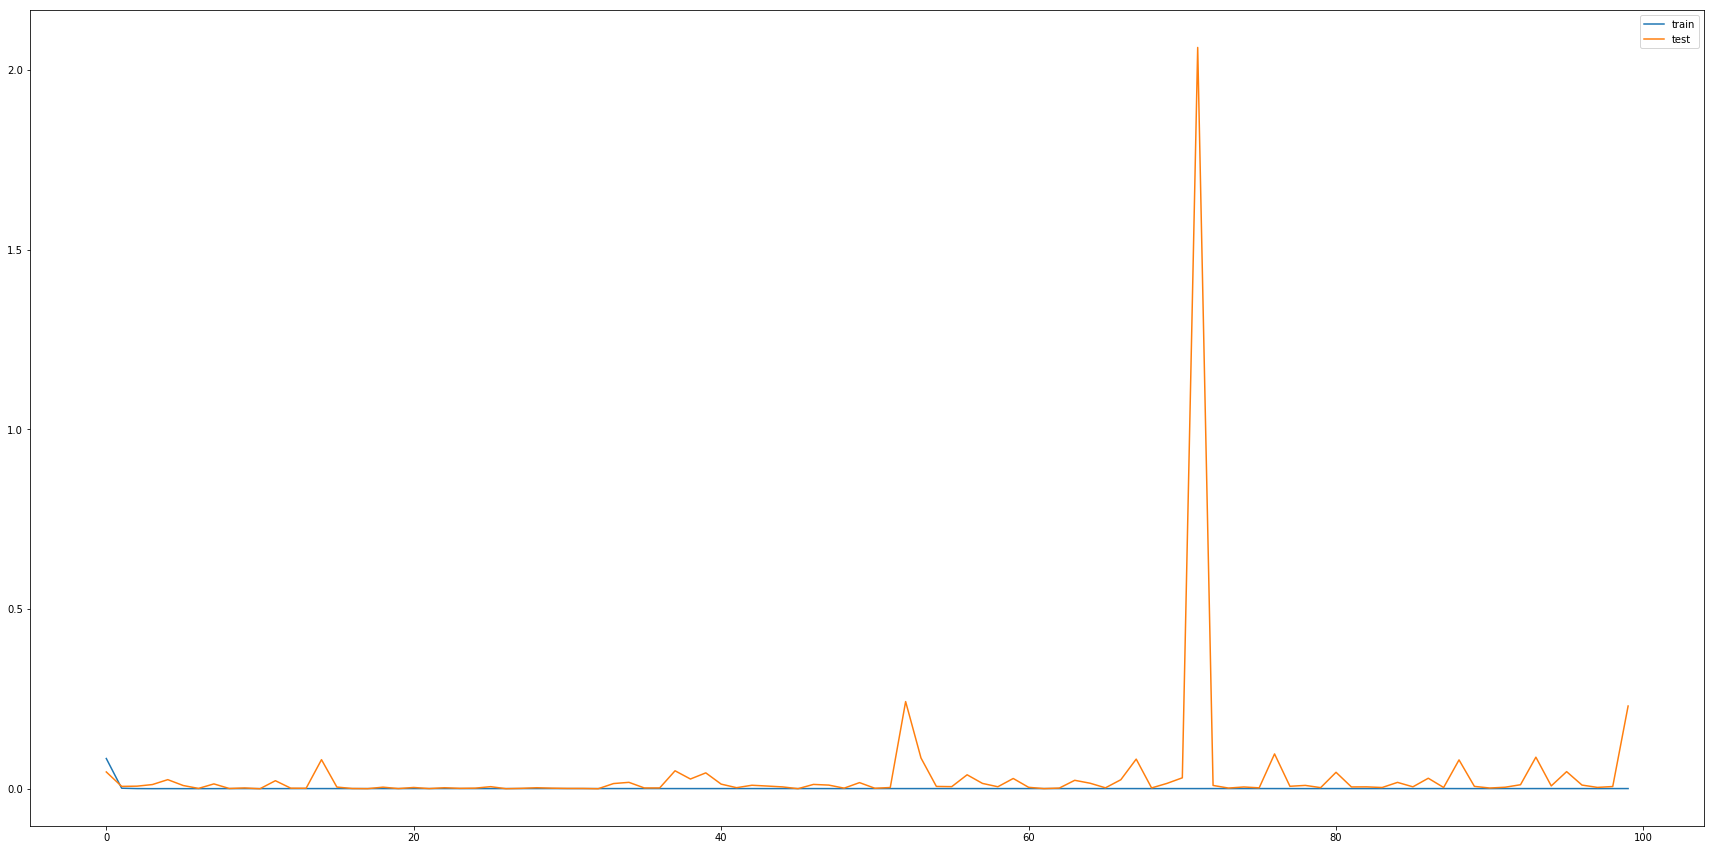

In [30]:
# plot history
plt.plot(history.history['loss'][:], label='train')
plt.plot(history.history['val_loss'][:], label='test')
plt.legend()
plt.show()

In [33]:
###
### Load model from best saved model
###

model = Sequential()

model.add(LSTM(512, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(GRU(512))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1))
model.load_weights("../output/tmp/model_lstm.hdf5")
model.compile(loss='mse', optimizer='adam')

In [34]:
###
### make a prediction
###

yhat = model.predict(test_X)
# print "Forecast : ", yhat[:,0].tolist()
# print "Test Y : ", test_y
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


Test RMSE: 322.926


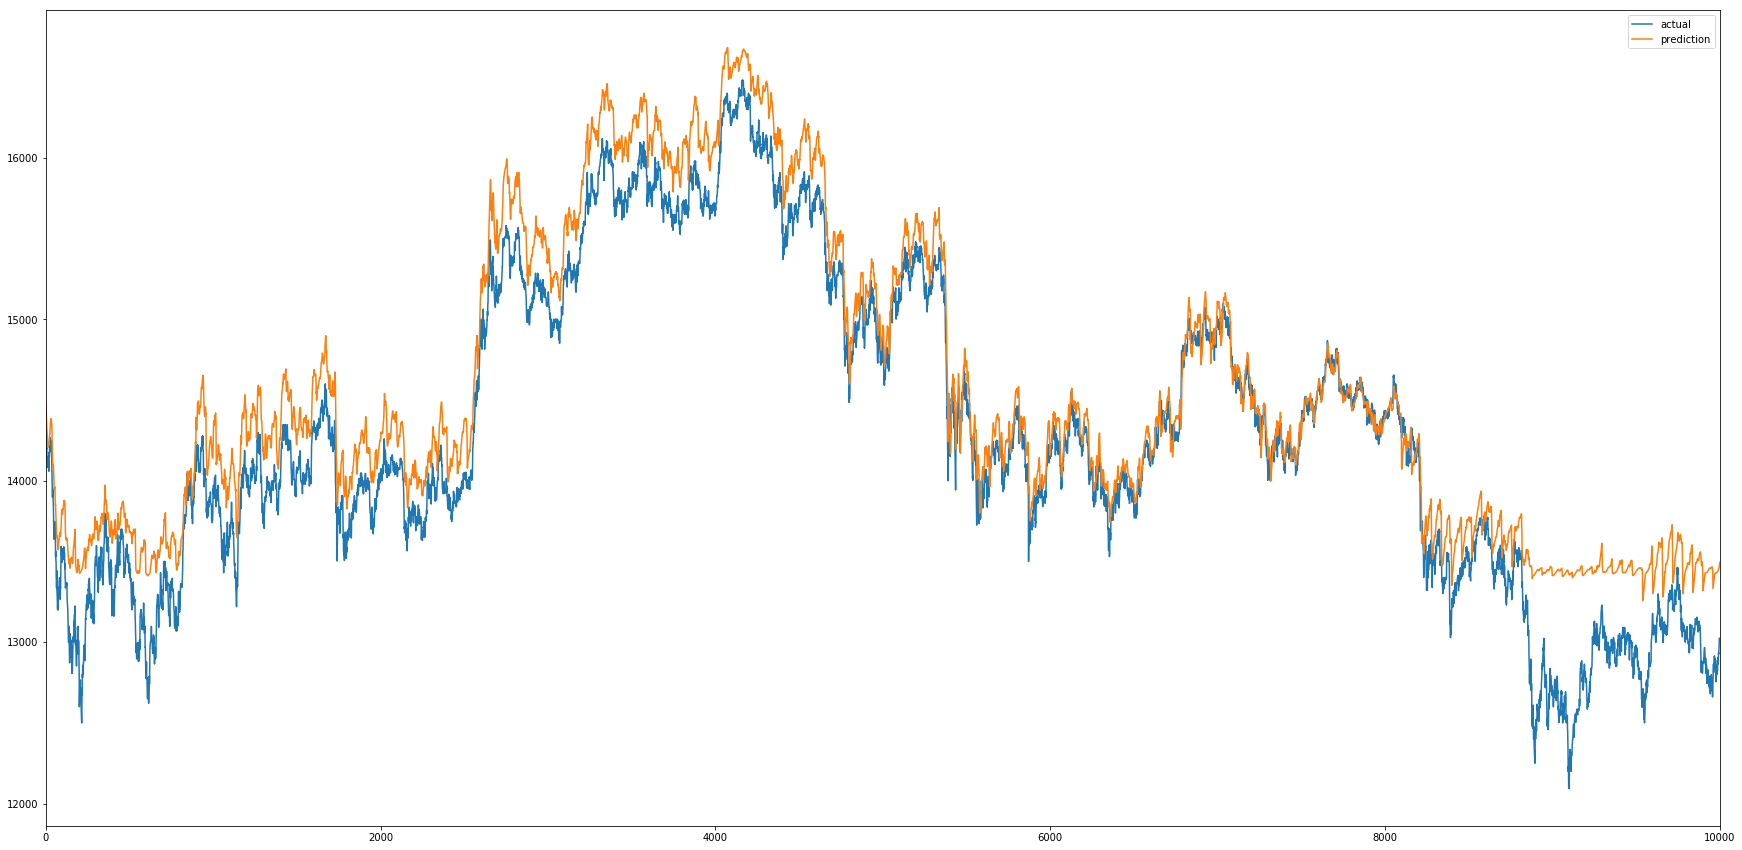

In [35]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print 'Test RMSE: %.3f' % rmse

result = pd.DataFrame()
result['actual'] = inv_y
result['prediction'] = inv_yhat
result.plot()

In [36]:
###
### To compare correct prediction of next Ups and Down data is prepared
### If next "Closing Price" value is > previous "Closing Price" value then it is marked as 1 else 0.
###

binary_op_actual, binary_op_pred = [], []
prev_val = 0
for i, val in enumerate(result['actual'].values):
    if i > 0:
        if val > prev_val:
            binary_op_actual.append(1)
        else:
            binary_op_actual.append(0)
    prev_val = val
        
prev_val = 0
for i, val in enumerate(result['prediction'].values):
    if i > 0:
        if val > prev_val:
            binary_op_pred.append(1)
        else:
            binary_op_pred.append(0)
    prev_val = val
        
print len(binary_op_actual), len(binary_op_pred)
print binary_op_actual[:10], binary_op_pred[:10]

9999 9999
[1, 0, 1, 0, 0, 1, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [37]:
from sklearn.metrics import classification_report

print classification_report(binary_op_actual, binary_op_pred)

             precision    recall  f1-score   support

          0       0.53      0.41      0.46      5212
          1       0.49      0.61      0.54      4787

avg / total       0.51      0.50      0.50      9999

